In [18]:
import slim_conservation_scoring.seqtools.general_utils as tools
import pandas as pd
import numpy as np
import slim_conservation_scoring.pipeline.group_conservation_objects as group_tools
import json
import os
import re
import sys
from pathlib import Path
from Bio import AlignIO, Seq, SeqIO, Align

import matplotlib.pyplot as plt
plt.style.use('custom_standard')
# plt.style.use('custom_small')
import seaborn as sns
# pd.options.plotting.backend = "plotly"

# %load_ext autoreload
# %autoreload 2

# import score key

In [19]:
def table_file_converter(table_file):
    return table_file.replace("/home/jch/Documents/08-benchmark", "..")


score_key_file = "../benchmark/benchmark_v4/p3_conservation/wide_form_tables_with_scores/score_key.csv"
score_key_df = pd.read_csv(score_key_file)
colmap = {
    "aln_property_entropy": "property_entropy",
    "aln_shannon_entropy": "shannon_entropy",
}
for i, row in score_key_df.iterrows():
    if row["score_key"] in colmap:
        score_key_df.at[i, "columnwise_score_function_name"] = colmap[row["score_key"]]

score_key_df = score_key_df.fillna("MSA")


def get_num_passing(table_file, score_key="hit_z_scores", filename_converter=None):
    if filename_converter is not None:
        table_file = filename_converter(table_file)
    df = pd.read_csv(table_file)
    return (~df[score_key].isna()).sum()


score_key_df["num_passing"] = score_key_df["table_file"].apply(
    get_num_passing, filename_converter=table_file_converter
)

## filter for vertebrates

In [20]:
score_key_filt = score_key_df[score_key_df['level'].isin(['Vertebrata'])].copy()
score_key_filt=score_key_filt.set_index('score_index', drop=True, verify_integrity=True)
score_indexes = list(score_key_filt.index)

# auPRC dependence on variables - scoring matrix, flank size, columnwise score

In [21]:
def import_score_table(score_index_df, score_index, filename_converter=None):
    table_file = score_index_df.loc[score_index, 'table_file']
    if filename_converter is not None:
        table_file = filename_converter(table_file)
    return pd.read_csv(table_file)

def import_multiple_scores(score_index_df, score_index_list, score_colname='hit_z_scores', filename_converter=None):
    df = import_score_table(score_index_df, score_index_list[0], filename_converter=filename_converter)
    df=df[
        [
            'reference_index',
            'ELM_motif_class',
            'verified interaction',
            'regex',
            'UniprotID',
            'name',
            'gene_id',
            'hit end position',
            'hit start position',
            'hit_sequence',
            'json_file',
            'bg_STD',
            score_colname,
        ]
    ]
    df = df.rename(columns={score_colname: score_index_list[0], 'bg_STD': f'{score_index_list[0]}-bg_STD'})
    for score_index in score_index_list[1:]:
        df2 = import_score_table(score_index_df, score_index, filename_converter=filename_converter)
        df2 = df2[['reference_index', score_colname, 'bg_STD']]
        df2 = df2.rename(columns={score_colname: score_index, 'bg_STD': f'{score_index}-bg_STD'})
        df = pd.merge(df, df2, on='reference_index', how='outer')
    return df

In [22]:
zscores = import_multiple_scores(
    score_key_filt, score_indexes, filename_converter=table_file_converter
)
zscores['hit_length'] = zscores['hit_sequence'].apply(len)
zscores["ELM_motif_class"] = zscores["ELM_motif_class"].replace(
    "enah_LPPPP_FPPPP", "Ena/VASP ([FL]PPPP)"
)

## add position masks just like `./n1-process_scores.ipynb`

In [23]:
temp = zscores[zscores['ELM_motif_class']=='LIG_14-3-3_CanoR_1'].copy()
l14_weights = {}
for l in temp['hit_length'].unique():
    l14_weights[l] = np.array([1.0]*l)

position_weights = {
    "DOC_WW_Pin1_4": np.array([0, 0, 0, 1, 1, 0]),  # ...([ST])P.
    "LIG_AP2alpha_2": np.array([1, 1, 1]),  # DP[FW]
    "LIG_EH_1": np.array([0, 1, 1, 1, 0]),  # .NPF.
    "LIG_SH2_GRB2like": np.array([1, 1, 1, 0]),  # (Y)([EDST]|[MLIVAFYHQW])N.
    "LIG_SH3_CIN85_PxpxPR_1": np.array([1, 0, 1, 0, 1, 1]),  # P.[AP].PR
    "Ena/VASP ([FL]PPPP)": np.array([1, 1, 0, 1, 1]),  # [FWYL]P.[AFILTVYWP]P
    "TRAF6": np.array([0,0,0,1,0,1,0,0,1]) # ...P.E..[FYWDE]
}# could use this for a weighted average score

zscores['mask_array'] = zscores.apply(lambda x: position_weights[x['ELM_motif_class']] if x['ELM_motif_class'] in position_weights else l14_weights[x['hit_length']], axis=1)
zscores["mask_array"] = zscores.apply(
    lambda x: (
        position_weights[x["ELM_motif_class"]]
        if x["ELM_motif_class"] in position_weights
        else l14_weights[x["hit_length"]]
    ),
    axis=1,
)

## filter for entries that are also in the main benchmark generated by `./n1-process_scores.ipynb`

In [24]:
PASSING_REF_ID_LIST = pd.read_csv("./z_scores_wideform.csv")['reference_index'].unique()

In [25]:
l = len(zscores)
# starting with only the entries that are also present in the benchmark above
zscores=zscores[zscores['reference_index'].isin(PASSING_REF_ID_LIST)].copy()
print(f'filtered out {l-len(zscores)} entries')
print('require all benchmark entries to have the other scores\n will drop:')
print(f'{zscores[score_indexes].isna().any(axis=1).sum()} entries')
zscores_temp=zscores.copy()
zscores=zscores.dropna(subset=score_indexes).copy()
print(f'dropped {l-len(zscores)} entries total')
from ast import literal_eval
for col in score_indexes:
    zscores[col] = zscores[col].apply(literal_eval)

filtered out 784 entries
require all benchmark entries to have the other scores
 will drop:
40 entries
dropped 824 entries total


an additional 40 entries were dropped 

In [38]:
failed_score_inds = list(zscores_temp[score_indexes].isna().sum()[zscores_temp[score_indexes].isna().sum()>0].index)
score_key_filt.loc[failed_score_inds]

,aln_type,level,score_key,table_file,lflank,rflank,columnwise_score_function_name,num_passing
score_index,,,,,,,,
16.0,Pairwise,Vertebrata,pairk_aln_lf10_rf10_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,10.0,10.0,shannon_entropy,2600
23.0,Pairwise,Vertebrata,pairk_aln_lf10_rf10_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,10.0,10.0,property_entropy,2600


They were dropped for the pairk method with 10 flanking residues. This is probably just because the k-mers were so large that there weren't enough unique k-mers comprising the background scores and were filtered out.

In [40]:
def extract_important_scores(s, colname):
    scores = np.array(s[colname])
    maskarr = np.array(s["mask_array"])
    mask = maskarr.nonzero()
    return scores[mask]

id_cols = [
    "reference_index",
    "ELM_motif_class",
    "verified interaction",
    "regex",
    "UniprotID",
    "name",
    "gene_id",
    "hit end position",
    "hit start position",
    "hit_sequence",
    "json_file",
    "hit_length",
    "mask_array",
]
z_long = zscores.melt(
    id_vars=id_cols,
    value_vars=score_indexes,
    var_name="score_index",
    value_name="z_scores",
)
z_long["masked_z_scores"] = z_long.apply(
    lambda x: extract_important_scores(x, "z_scores"), axis=1
)
z_long["conservation_score"] = z_long["masked_z_scores"].apply(np.mean)
z_long=z_long[z_long["ELM_motif_class"] != "TRAF6"]
z_long.sample(5)

,reference_index,ELM_motif_class,verified interaction,regex,UniprotID,name,gene_id,hit end position,hit start position,hit_sequence,json_file,hit_length,mask_array,score_index,z_scores,masked_z_scores,conservation_score
24830,1763,DOC_WW_Pin1_4,False,...([ST])P.,P18146,NaN,9606_0:001886,13,8,QLMSPL,/home/jch/Documents/08-benchmark/benchmark/ben...,6,"[0, 0, 0, 1, 1, 0]",19.0,"[-1.6416733441931832, 1.3225502712291541, 0.77...","[-0.945449279169919, -0.8932298330345485]",-0.919340
1826,2556,Ena/VASP ([FL]PPPP),False,[FL]PPPP,A0A654IC68,NaN,9606_0:003ef3,241,237,LPPPP,/home/jch/Documents/08-benchmark/benchmark/ben...,5,"[1, 1, 0, 1, 1]",2.0,"[-0.915662613575864, -1.3139008675084372, -1.7...","[-0.915662613575864, -1.3139008675084372, -1.3...",-1.232456
33973,2539,Ena/VASP ([FL]PPPP),False,[FL]PPPP,Q7Z6J0,NaN,9606_0:001373,402,398,LPPPP,/home/jch/Documents/08-benchmark/benchmark/ben...,5,"[1, 1, 0, 1, 1]",23.0,"[-0.5176424317929985, 0.3146184916646005, -0.0...","[-0.5176424317929985, 0.3146184916646005, -0.2...",0.080019
12514,2507,Ena/VASP ([FL]PPPP),False,[FL]PPPP,Q05GC8,NaN,9606_0:0019f5,563,559,LPPPP,/home/jch/Documents/08-benchmark/benchmark/ben...,5,"[1, 1, 0, 1, 1]",13.0,"[0.3350551258758782, -0.12342525094969481, 0.5...","[0.3350551258758782, -0.12342525094969481, 0.8...",0.290801
13705,1151,LIG_SH2_GRB2like,False,(Y)([EDST]|[MLIVAFYHQW])N.,A0A024R9X7,NaN,9606_0:004da8,364,361,YTNQ,/home/jch/Documents/08-benchmark/benchmark/ben...,4,"[1, 1, 1, 0]",14.0,"[1.1694216379550821, 0.6284511012725175, 1.022...","[1.1694216379550821, 0.6284511012725175, 1.022...",0.940177


In [41]:
classes = list(z_long['ELM_motif_class'].unique())
class_list, score_inds, auprc_list = [], [], []
for cl in classes:
    for c, i in enumerate(z_long['score_index'].unique()):
        df_filtered = z_long[z_long['score_index']==i]
        df_copy = df_filtered[df_filtered['ELM_motif_class'] == cl].copy()
        prc_results = tools.df_2_precision_recall_curve(df_copy, 'verified interaction', 'conservation_score')
        class_list.append(cl)
        score_inds.append(i)
        auprc_list.append(prc_results[3])
auprc_df = pd.DataFrame({'ELM_motif_class': class_list, 'score_index': score_inds, 'auPRC': auprc_list})
auprc_df = pd.merge(auprc_df, score_key_filt, on='score_index', how='left')

In [42]:
auprc_df['score_key'].value_counts()

score_key
pairk_aln_lf0_rf0_blosum62               14
pairk_aln_lf0_rf0_edssmat50              14
pairk_aln_lf0_rf0_grantham               14
pairk_aln_lf5_rf5_edssmat50              14
pairk_aln_lf10_rf10_edssmat50            14
pairk_aln_needleman_lf0_rf0_edssmat50    14
pairk_aln_lf2_rf2_edssmat50              14
pairk_aln_embedding_lf0_rf0              14
pairk_aln_dr_bert_embedding_lf0_rf0      14
aln_shannon_entropy                       7
aln_property_entropy                      7
Name: count, dtype: int64

In [48]:
# temp = auprc_df_norm[auprc_df_norm['ELM_motif_class']!='TRAF6']
temp = auprc_df.copy()
temp = temp[(temp['aln_type']!='Pairwise embedding')].copy()
temp = temp[(temp['columnwise_score_function_name']!='shannon_entropy')&(~temp['score_key'].isin(['pairk_aln_lf0_rf0_blosum62', 'pairk_aln_lf5_rf5_blosum62', 'pairk_aln_lf0_rf0_grantham', 'pairk_aln_needleman_lf0_rf0_edssmat50']))].copy()
temp['lflank'] = temp['lflank'].apply(lambda x: str(int(x)) if isinstance(x, float) else x)
temp['score_key'].value_counts()

score_key
aln_property_entropy             7
pairk_aln_lf0_rf0_edssmat50      7
pairk_aln_lf2_rf2_edssmat50      7
pairk_aln_lf5_rf5_edssmat50      7
pairk_aln_lf10_rf10_edssmat50    7
Name: count, dtype: int64

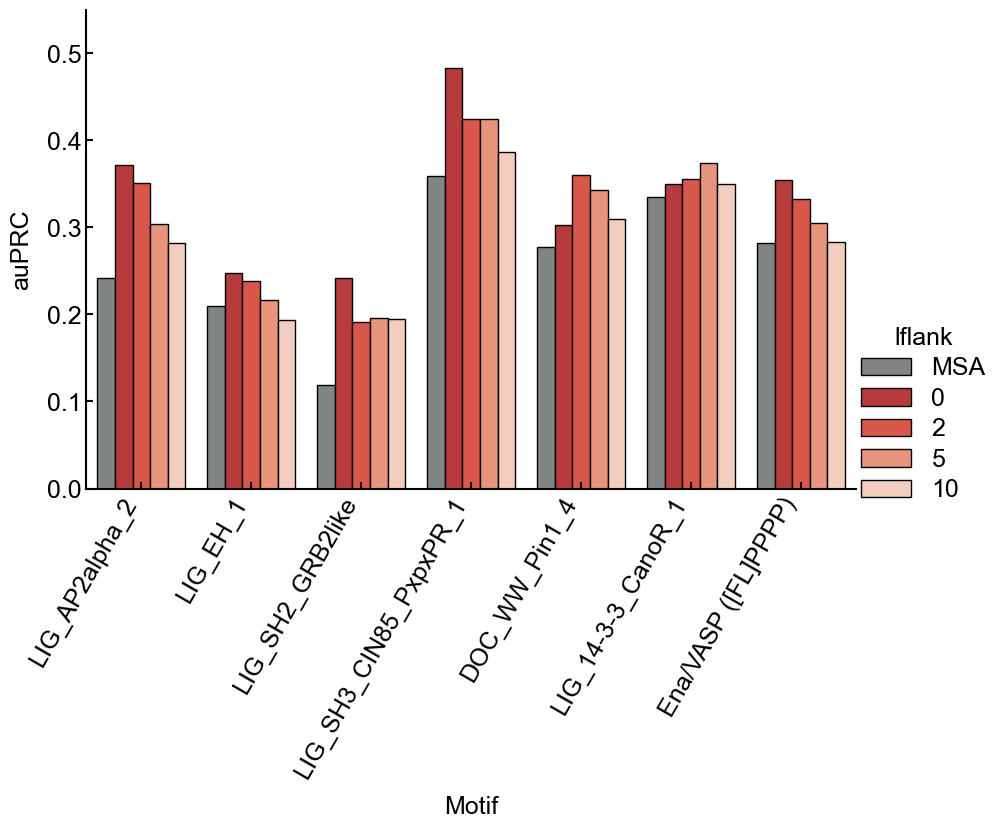

In [49]:
plot = sns.catplot(
    data=temp,
    x="ELM_motif_class",
    y="auPRC",
    hue="lflank",
    kind="bar",
    height=6,
    aspect=1.5,
    hue_order=[
        'MSA',
        '0',
        '2',
        '5',
        '10',
    ],
    palette={
        'MSA':'#7f8585',
        '0': '#cc2529',
        # '0': '#FCC9B4',
        '2': '#F14432',
        '5': '#FB8A6A',
        '10': '#FCC9B4',
        # '10': '#BB1419',
    },
)
plot.set(ylim=(0.0, 0.55))
plot.set_xticklabels(rotation=60, horizontalalignment="right")
# plot._legend.remove()
plot.set_xlabels('Motif')
supp_folder = Path('./supplement/')
output_folder = supp_folder / 'performance_of_pairwise_variants'
output_folder.mkdir(exist_ok=True, parents=True)
plt.savefig(output_folder / 'flank-PE-rbm_f-_vertebrata.png', bbox_inches='tight', dpi=400)

In [50]:
# temp = auprc_df_norm[auprc_df_norm['ELM_motif_class']!='TRAF6']
temp = auprc_df.copy()
temp = temp[
    (temp["aln_type"] != "Pairwise embedding")
].copy()
temp = temp[temp["columnwise_score_function_name"] != "shannon_entropy"].copy()
temp=temp[
    temp["score_key"].isin(
        [
            "pairk_aln_lf0_rf0_edssmat50",
            "pairk_aln_lf0_rf0_grantham",
            "pairk_aln_lf0_rf0_blosum62",
        ]
    )
].copy()

In [51]:
temp.score_key.value_counts()

score_key
pairk_aln_lf0_rf0_blosum62     7
pairk_aln_lf0_rf0_grantham     7
pairk_aln_lf0_rf0_edssmat50    7
Name: count, dtype: int64

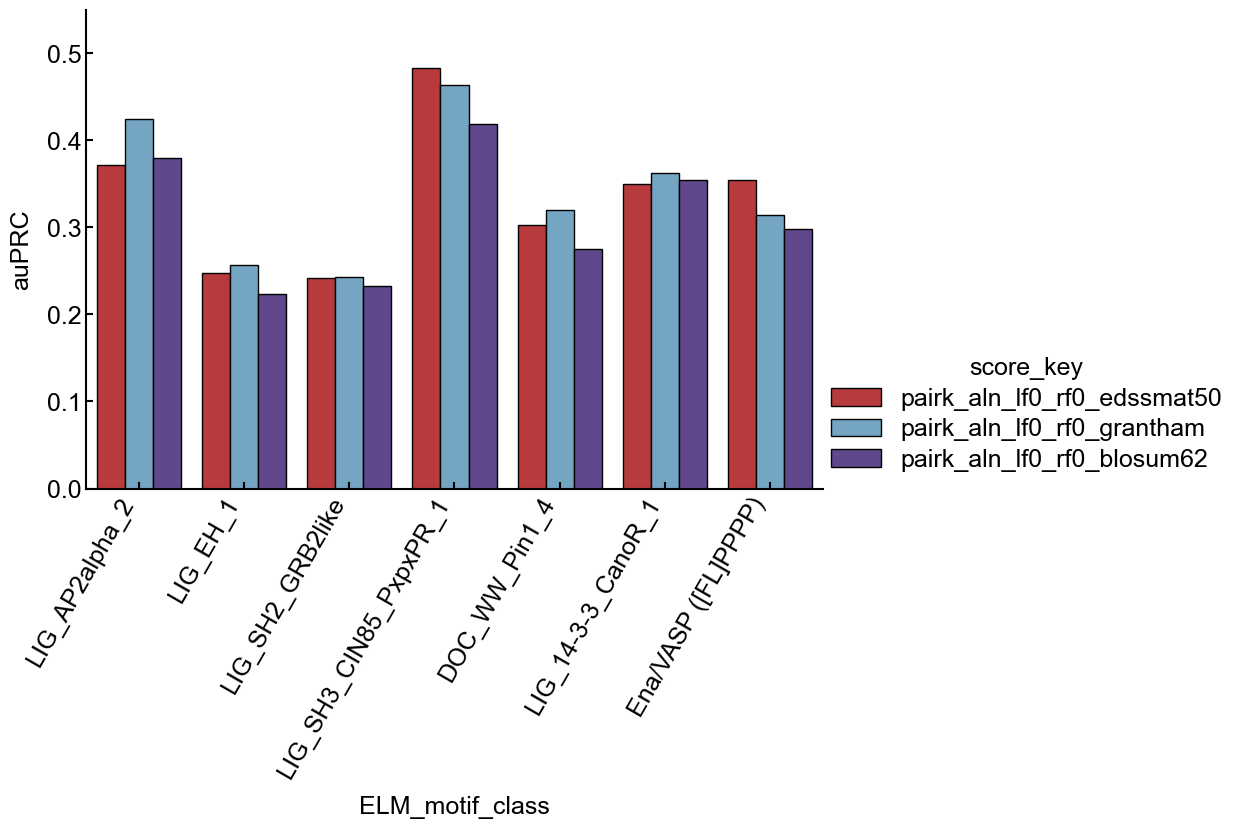

In [52]:
# fig, ax = plt.subplots(figsize=(10, 6))

plot = sns.catplot(
    data=temp,
    x="ELM_motif_class",
    y="auPRC",
    hue="score_key",
    hue_order=[
        "pairk_aln_lf0_rf0_edssmat50",
        "pairk_aln_lf0_rf0_grantham",
        "pairk_aln_lf0_rf0_blosum62",
    ],
    palette={
        "pairk_aln_lf0_rf0_edssmat50":'#cc2529',
        "pairk_aln_lf0_rf0_grantham": '#67a9cf',
        "pairk_aln_lf0_rf0_blosum62": '#5e3c99',
        # "pairk_aln_lf0_rf0_blosum62": '#ef8a62',
    },
    kind="bar",
    height=6,
    aspect=1.5,
    legend=True,
    # ax=ax,
)
plot.set_xticklabels(rotation=60, horizontalalignment="right")
# plt.xticks(rotation=60, horizontalalignment="right")
# ax.set_ylim([0, 0.55])
# set y limits
plot.set(ylim=(0.0, 0.55))
# plot._legend.remove()
supp_folder = Path('./supplement/')
output_folder = supp_folder / 'performance_of_pairwise_variants'
output_folder.mkdir(exist_ok=True, parents=True)
plt.savefig(output_folder / 'matrices-PE-rbm_f-_vertebrata.png', bbox_inches='tight', dpi=400)

In [53]:
temp = auprc_df.copy()
temp = temp[
    (temp["aln_type"] != "Pairwise embedding")
].copy()
temp=temp[
    temp["score_key"].isin(
        [
            "pairk_aln_lf0_rf0_edssmat50",
            "aln_shannon_entropy",
            "aln_property_entropy",
        ]
    )
].copy()
temp['score_index'] = temp['score_index'].apply(lambda x: str(int(x)) if isinstance(x, float) else x)
temp.score_key.value_counts()

score_key
pairk_aln_lf0_rf0_edssmat50    14
aln_property_entropy            7
aln_shannon_entropy             7
Name: count, dtype: int64

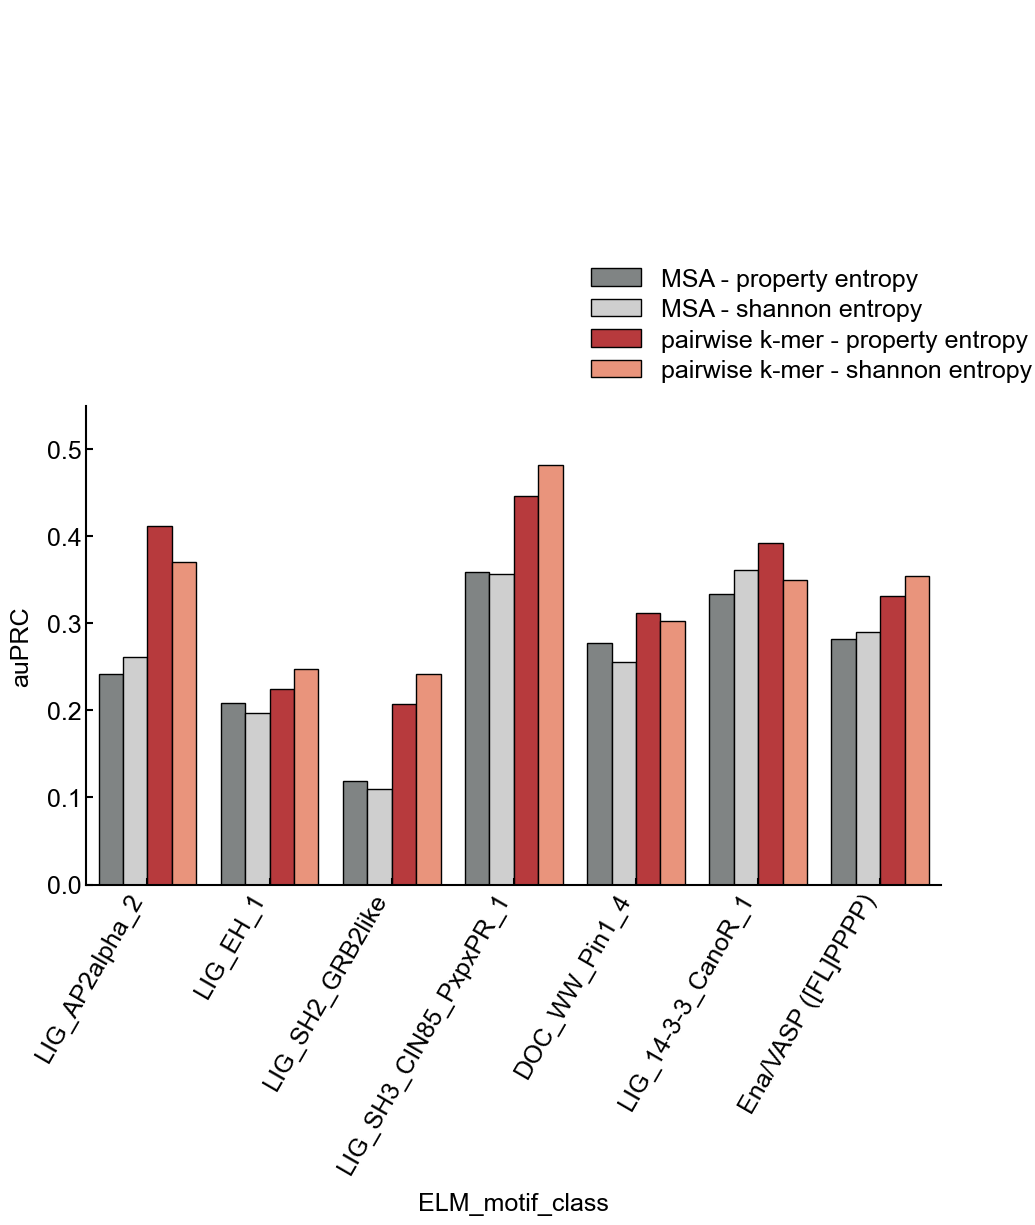

In [55]:
# fig, ax = plt.subplots(figsize=(10, 6))
plot = sns.catplot(
    data=temp,
    x="ELM_motif_class",
    y="auPRC",
    hue="score_index",
    hue_order=['2', '3','12', '19'],
    palette={
        '2':'#7f8585',
        '3':'#cfcfcf',
        '12':'#cc2529',
        '19':'#FB8A6A',
        # "shannon_entropy": '#5e3c99',
        # "fragpair_gapless_lf0_rf0_blosum62": '#ef8a62',
    },
    kind="bar",
    height=6,
    aspect=1.5,
    legend=True,
    # ax=ax,
)

# set the legend labels
plot._legend.set_title('')
new_labels = ['MSA - property entropy', 'MSA - shannon entropy', 'pairwise k-mer - property entropy', 'pairwise k-mer - shannon entropy']
for t, l in zip(plot._legend.texts, new_labels): t.set_text(l)
# move the legend outside the plot
plot._legend.set_bbox_to_anchor((1, 1.5))
plt.tight_layout()


plot.set_xticklabels(rotation=60, horizontalalignment="right")
# plt.xticks(rotation=60, horizontalalignment="right")
# ax.set_ylim([0, 0.55])
# set y limits
plot.set(ylim=(0.0, 0.55))
# plot._legend.remove()
supp_folder = Path('./supplement/')
output_folder = supp_folder / 'performance_of_pairwise_variants'
output_folder.mkdir(exist_ok=True, parents=True)
plt.savefig(output_folder / 'shannon_v_PE-rbm_f-_vertebrata.png', bbox_inches='tight', dpi=400)

---

# ignore the rest of the notebook

auPRC - see `n2-bootstrapping_auprc_scores.ipynb` for final plots

In [52]:
zscores = pd.read_csv('./z_scores_wideform.csv')
score_key = pd.read_csv('./z_scores_score_key.csv')
score_indexes=[i for i in zscores.columns if i in score_key['score_index'].unique()]

from ast import literal_eval
for col in score_indexes:
    zscores[col] = zscores[col].apply(literal_eval)

zscores['mask_array'] = zscores['mask_array'].str.replace(' ', ',')
zscores['mask_array'] = zscores['mask_array'].apply(literal_eval)

def extract_important_scores(s, colname):
    scores = np.array(s[colname])
    maskarr = np.array(s["mask_array"])
    mask = maskarr.nonzero()
    return scores[mask]

zscores2=zscores.copy()
for i in score_indexes:
    zscores2[i] = zscores2.apply(lambda x: extract_important_scores(x, i), axis=1)
    zscores2[i] = zscores2[i].apply(np.mean)
zscores2 = zscores2[zscores2['ELM_motif_class'] != 'TRAF6']
for i in zscores2.columns: print(i)

reference_index
ELM_motif_class
verified interaction
regex
UniprotID
name
gene_id
hit end position
hit start position
hit_sequence
json_file
0.0-bg_STD
0.0
2.0
2.0-bg_STD
4.0
4.0-bg_STD
8.0
8.0-bg_STD
9.0
9.0-bg_STD
19.0
19.0-bg_STD
22.0
22.0-bg_STD
26.0
26.0-bg_STD
27.0
27.0-bg_STD
30.0
30.0-bg_STD
31.0
31.0-bg_STD
34.0
34.0-bg_STD
35.0
35.0-bg_STD
38.0
38.0-bg_STD
39.0
39.0-bg_STD
hit_length
mask_array
kibby_hit_zscores-bg_STD
kibby_hit_zscores


In [54]:
id_cols = [
    'reference_index',
    'ELM_motif_class',
    'verified interaction',
    'regex',
    'UniprotID',
    'name',
    'gene_id',
    'hit end position',
    'hit start position',
    'hit_sequence',
    'json_file',
    'hit_length',
    'mask_array',
]
z_long = zscores2.melt(id_vars=id_cols, value_vars=score_indexes, var_name='score_index', value_name='conservation_score')

## general auPRC

In [57]:
score_inds, auprc_list = [], []
for i in z_long['score_index'].unique():
    df_filtered = z_long[z_long['score_index']==i].copy()
    assert df_filtered['reference_index'].duplicated().sum()==0, 'duplicates in reference index'
    prc_results = tools.df_2_precision_recall_curve(df_filtered, 'verified interaction', 'conservation_score')
    score_inds.append(i)
    auprc_list.append(prc_results[3])
general_auprc_df = pd.DataFrame({'score_index': score_inds, 'auPRC': auprc_list})

In [58]:
general_auprc_df= pd.merge(general_auprc_df, score_key, on='score_index', how='left')

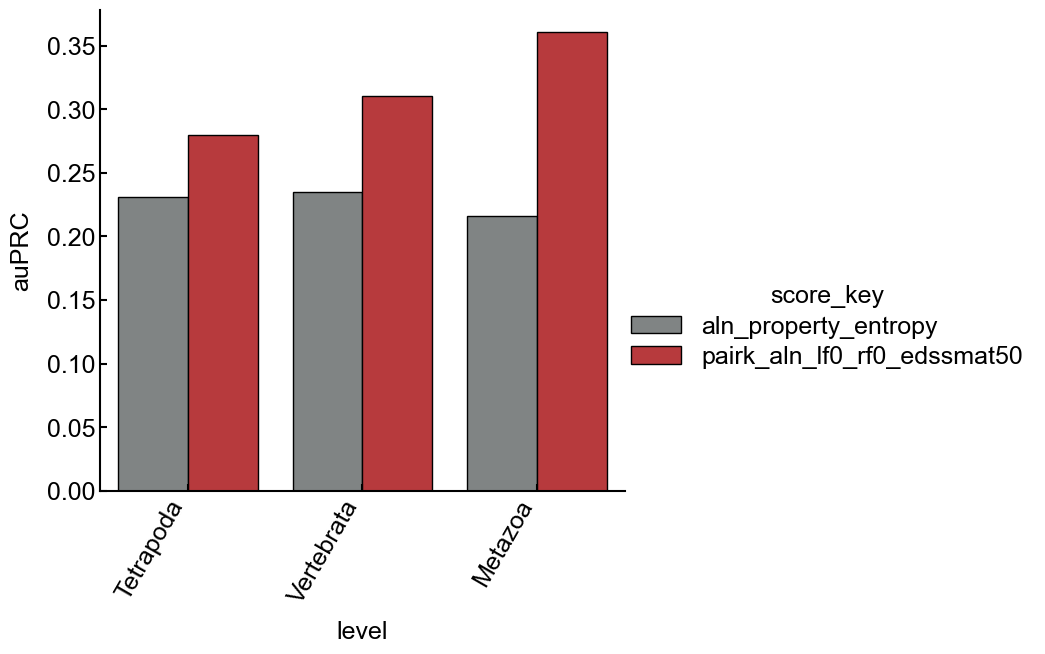

In [60]:
plot = sns.catplot(
    data=general_auprc_df[
        (general_auprc_df['rflank']!=5)
    ],
    y="auPRC",
    hue='score_key',
    x='level',
    kind='bar',
    aspect=1.2,
    height=6,
    hue_order=[
        'aln_property_entropy',
        'pairk_aln_lf0_rf0_edssmat50',
        # 'frag_pairwise_gapless_embedding_lf0_rf0',
        # 'kibby',
    ],
    palette={'aln_property_entropy': '#7f8585', 'kibby': '#b2abd2', 'pairk_aln_lf0_rf0_edssmat50': '#cc2529', 'frag_pairwise_gapless_embedding_lf0_rf0':'#fdb863'},
)
plot.set_xticklabels(rotation=60, horizontalalignment="right")
# plot.set(ylim=(0.0, 0.45))

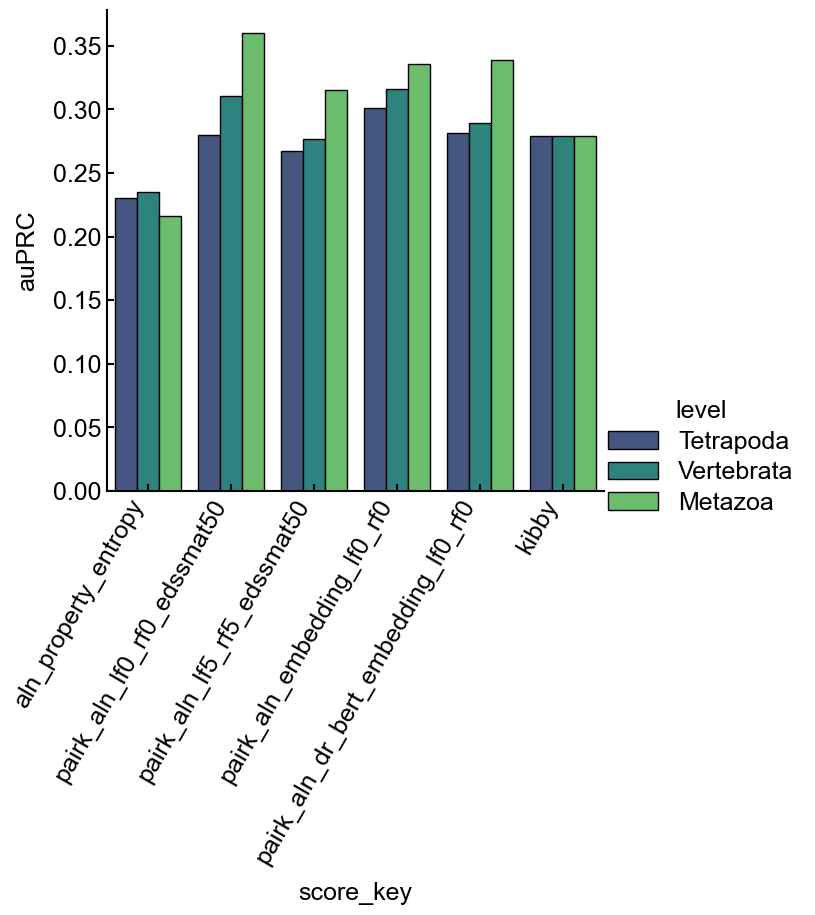

In [61]:
plot = sns.catplot(
    data=general_auprc_df[
        (general_auprc_df['rflank']!=5)
    ],
    y="auPRC",
    x='score_key',
    hue='level',
    kind='bar',
    aspect=1.1,
    height=6,
    palette='viridis',
)
plot.set_xticklabels(rotation=60, horizontalalignment="right")

## per class

In [62]:
classes = list(z_long['ELM_motif_class'].unique())
class_list, score_inds, auprc_list = [], [], []
scores = z_long['score_index'].unique()
for cl in classes:
    for c, i in enumerate(z_long['score_index'].unique()):
        df_filtered = z_long[z_long['score_index']==i]
        df_copy = df_filtered[df_filtered['ELM_motif_class'] == cl].copy()
        prc_results = tools.df_2_precision_recall_curve(df_copy, 'verified interaction', 'conservation_score')
        class_list.append(cl)
        score_inds.append(i)
        auprc_list.append(prc_results[3])
auprc_df = pd.DataFrame({'ELM_motif_class': class_list, 'score_index': score_inds, 'auPRC': auprc_list})
auprc_df = pd.merge(auprc_df, score_key, on='score_index', how='left')

aln_df=auprc_df[auprc_df['aln_type']=='MSA - MAFFT'][["ELM_motif_class", "auPRC", "level"]].copy()
auprc_df_norm=pd.merge(auprc_df, aln_df, on=['ELM_motif_class', 'level'], how='left', suffixes=('', '_aln'))

auprc_df_norm["auPRC_diff"] = auprc_df_norm["auPRC"] - auprc_df_norm["auPRC_aln"]
auprc_df_norm["auPRC_increase"] = auprc_df_norm["auPRC"] / auprc_df_norm["auPRC_aln"]
auprc_df_norm["auPRC_log_increase"] = np.log10(
    auprc_df_norm["auPRC"] / auprc_df_norm["auPRC_aln"]
)
auprc_df_norm.tail(10)

,ELM_motif_class,score_index,auPRC,aln_type,level,score_key,table_file,lflank,rflank,columnwise_score_function_name,num_passing,auPRC_aln,auPRC_diff,auPRC_increase,auPRC_log_increase
116,Ena/VASP ([FL]PPPP),27.0,0.348915,Pairwise,Metazoa,pairk_aln_lf5_rf5_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,5.0,5.0,property_entropy,2738,0.265646,0.083269,1.313459,0.118416
117,Ena/VASP ([FL]PPPP),30.0,0.287523,Pairwise embedding,Tetrapoda,pairk_aln_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2663,0.280820,0.006703,1.023870,0.010245
118,Ena/VASP ([FL]PPPP),31.0,0.258403,Pairwise embedding,Tetrapoda,pairk_aln_dr_bert_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2663,0.280820,-0.022417,0.920172,-0.036131
119,Ena/VASP ([FL]PPPP),34.0,0.322193,Pairwise embedding,Vertebrata,pairk_aln_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2823,0.281243,0.040949,1.145602,0.059034
120,Ena/VASP ([FL]PPPP),35.0,0.282446,Pairwise embedding,Vertebrata,pairk_aln_dr_bert_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2823,0.281243,0.001203,1.004277,0.001853
121,Ena/VASP ([FL]PPPP),38.0,0.319287,Pairwise embedding,Metazoa,pairk_aln_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2844,0.265646,0.053641,1.201926,0.079878
122,Ena/VASP ([FL]PPPP),39.0,0.297819,Pairwise embedding,Metazoa,pairk_aln_dr_bert_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2844,0.265646,0.032173,1.121113,0.049649
123,Ena/VASP ([FL]PPPP),kibby_hit_zscores,0.363260,kibby,Metazoa,kibby,kibby,kibby,kibby,kibby,kibby,0.265646,0.097614,1.367460,0.135915
124,Ena/VASP ([FL]PPPP),kibby_hit_zscores,0.363260,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby,0.280820,0.082441,1.293571,0.111790
125,Ena/VASP ([FL]PPPP),kibby_hit_zscores,0.363260,kibby,Vertebrata,kibby,kibby,kibby,kibby,kibby,kibby,0.281243,0.082017,1.291624,0.111136


In [63]:
temp['ELM_motif_class'].unique()

array(['LIG_AP2alpha_2', 'LIG_EH_1', 'LIG_SH2_GRB2like',
       'LIG_SH3_CIN85_PxpxPR_1', 'DOC_WW_Pin1_4', 'LIG_14-3-3_CanoR_1',
       'Ena/VASP ([FL]PPPP)'], dtype=object)

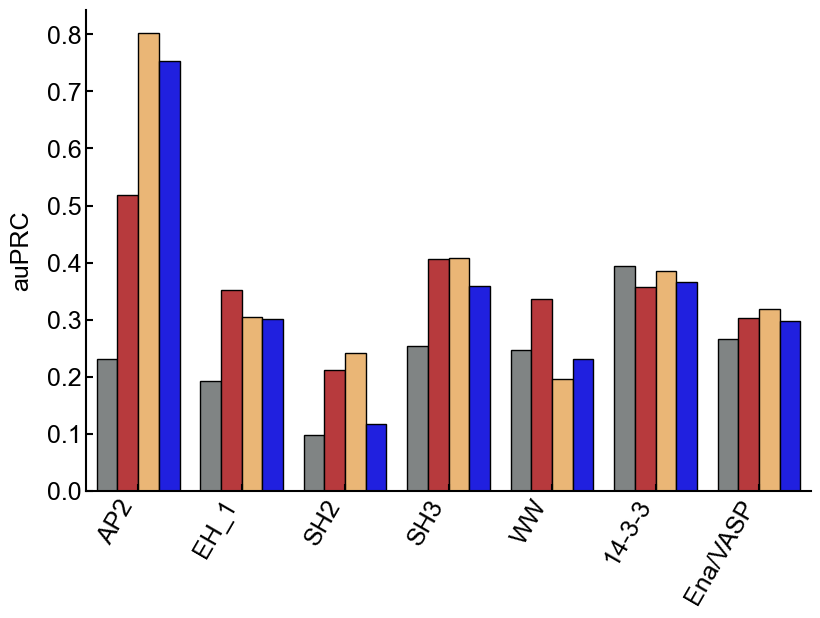

In [64]:
# temp = auprc_df_norm[auprc_df_norm['ELM_motif_class']!='TRAF6']
plt.rcParams['axes.labelsize'] = 18
temp = auprc_df_norm.copy()
temp = temp[(temp['level']=='Metazoa')].copy()
temp = temp[temp['rflank']!=5]
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('Ena/VASP ([FL]PPPP)', 'Ena/VASP')
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('LIG_AP2alpha_2', 'AP2')
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('LIG_EH_1', 'EH_1')
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('LIG_SH2_GRB2like', 'SH2')
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('LIG_SH3_CIN85_PxpxPR_1', 'SH3')
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('DOC_WW_Pin1_4', 'WW')
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('LIG_14-3-3_CanoR_1', '14-3-3')
plot = sns.catplot(
    data=temp,
    x="ELM_motif_class",
    y="auPRC",
    hue="score_key",
    kind="bar",
    height=6,
    aspect=1.5,
    hue_order=[
        'aln_property_entropy',
        'pairk_aln_lf0_rf0_edssmat50',
        'pairk_aln_embedding_lf0_rf0',
        'pairk_aln_dr_bert_embedding_lf0_rf0'
        # 'kibby',
    ],
    # col="lflank",
    # row='level',
    palette={'aln_property_entropy': '#7f8585', 'kibby': '#b2abd2', 'pairk_aln_lf0_rf0_edssmat50': '#cc2529', 'pairk_aln_embedding_lf0_rf0':'#fdb863', 'pairk_aln_dr_bert_embedding_lf0_rf0':'blue'},
)
# make tick labels smaller
plot.set_xticklabels(rotation=60, horizontalalignment="right")
# plot.set_xticklabels(rotation=60, horizontalalignment="right", fontsize=14)
# plot.set_yticklabels(fontsize=18)
plot._legend.remove()
plot.set_xlabels('')
# plt.ylim([0, 0.5])
# plt.tight_layout()
# plt.savefig('./figure3/auPRC_barplot_classes_metazoa-rbm_f.png', bbox_inches='tight', dpi=400)